# Polars: Blazingly fast dataframes!! 🚀🚀

Agenda

* Polars in a nutshell
* Blazingly fast claim
* Coming from pandas
* Example: Expression language

## Polars in a nutshell

* An in memory query engine + DataFrame library written from scratch in Rust
    - Rust: memory safe programming language w/. performance == C/C++
    - Full control over memory / close to the metal

<div>
:<img src="img/rustlang.png" width="200"</img>
</div>

* Apache Arrow as memory model
    - The future of big data communication and columnar store
    
![arrowimg](https://arrow.apache.org/img/shared.png)

* Written for the hardware
    * Moores law is at end (so instead we get tons of cores)
    * Still large memory latencies.

## Title claim

* Mix those 2 great technologies with several lockdowns of time...

* **One of best performing query engines**

<div>
<img src="img/db-benchmark.png" width=700>
</div>

# Let's get a feel for that on 0.5 GB

* `$ SRC_DATANAME=G1_1e7_1e2_0_0 polars/groupby-polars.py`
* `$ SRC_DATANAME=G1_1e7_1e2_0_0 polars/groupby-pandas.py`


# Coming from pandas

## Performance
*  5-20x pandas (in db-benchmark)

## Memory requirements (for algorithms)
* pandas: ~10x dataset size (according to pandas dev)
* polars: ~2/3x dataset size



## Coming from pandas (design): first class dtypes

### Missing data != `NaN`

* adding missing values, can cause dtype changes

```python
assert pd.DataFrame({"integers": [1, None, 2]}).dtypes[0] == np.int64
```

```
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<ipython-input-13-88b9defd12a1> in <module>
----> 1 assert pd.DataFrame({"integers": [1, None, 2]}).dtypes[0] == np.int64

AssertionError: 
```



## Coming from pandas (design): first class dtypes

### String data are boxed python objects

```python
pd.DataFrame({"strings": ["foo", "ham", "bar"]}).dtypes
```

```
strings    object
dtype: object
```

<div>
<img src="img/pandas-string.svg"</img>
</div>

## Coming from pandas (design): no indexes

_my subjective claims_

* Code is read more often than written.
* Usage of indexes in the wild cost more compute than what they should save

* I never understood them much (ironically)

## No indexes gives us predictable indexing

```
df.iloc # not needed
df.loc # not needed
```

https://pola-rs.github.io/polars-book/user-guide/indexing.html#comparison-with-pandas

#[cfg(feature = "pretty_fmt")]
use comfy_table::modifiers::UTF8_ROUND_CORNERS;
## Coming from pandas (design): Free cloning

**pandas:**
```
    
[..............]

copy:
    - [..............]
copy:
    - [..............]
```


**polars:**
```
    
RC<[..............]> 

copy:
    - *ptr
copy:
    - *ptr
```



* immutable -> copy on write semantics
* easy to write pure functions
* No `SettingWithCopyWarning`


## Coming from pandas (design): Lazy evaluation

Polars is:

* eager
* semi-lazy.
* lazy


Idiomatic polars is:
* semi-lazy.
* lazy

## This yields
* Context
* Optimizations
* Readability -> write your intention, not how to do it

In [1]:
import polars as pl
from polars import col, lit, when

# Expressions

`fn(Series) -> Series`

* Lazily evaluated
    - Can be optimized
    - Gives the library writer context and informed decision can be made
* Embarassingly parallel
* Context dependent
    - selection / projection -> `Series` = **COLUMN, LITERAL or VALUE**
    - aggregation -> `Series` = **GROUPS**


In [2]:
df = pl.DataFrame(
    {
        "A": [1, 2, 3, 4, 5],
        "fruits": ["banana", "banana", "apple", "apple", "banana"],
        "B": [5, 4, 3, 2, 1],
        "cars": ["beetle", "audi", "beetle", "beetle", "beetle"],
        "optional": [28, 300, None, 2, -30],
    }
)
df

A,fruits,B,cars,optional
i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28
2,"""banana""",4,"""audi""",300
3,"""apple""",3,"""beetle""",null
4,"""apple""",2,"""beetle""",2
5,"""banana""",1,"""beetle""",-30


# Selection context

In [17]:
# We can select by name
(df.select([
    col("A"),
    "B",      # the col part is inferred
    lit("B"),  # we must tell polars we mean the literal "B"
    col("fruits"),
]))

A,B,literal,fruits
i64,i64,str,str
1,5,"""B""","""banana"""
2,4,"""B""","""banana"""
3,3,"""B""","""apple"""
4,2,"""B""","""apple"""
5,1,"""B""","""banana"""


In [18]:
# you can select columns with a regex if it starst with '^' and ends with '$'

(df.select([
    col("^A|B$").sum()
]))

A,B
i64,i64
15,15


In [19]:
# you can select multiple columns by name

(df.select([
    col(["A", "B"]).sum()
]))

A,B
i64,i64
15,15


In [20]:
# We select everything in normal order
# Then we select everything in reversed order
(df.select([
    pl.all(),
    pl.all().reverse().suffix("_reverse")
]))

A,fruits,B,cars,optional,A_reverse,fruits_reverse,B_reverse,cars_reverse,optional_reverse
i64,str,i64,str,i64,i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28,5,"""banana""",1,"""beetle""",-30
2,"""banana""",4,"""audi""",300,4,"""apple""",2,"""beetle""",2
3,"""apple""",3,"""beetle""",null,3,"""apple""",3,"""beetle""",null
4,"""apple""",2,"""beetle""",2,2,"""banana""",4,"""audi""",300
5,"""banana""",1,"""beetle""",-30,1,"""banana""",5,"""beetle""",28


In [21]:
# all expressions run in parallel
# single valued `Series` are broadcasted to the shape of the `DataFrame`
(df.select([
    pl.all(),
    pl.all().sum().suffix("_sum")
]))

A,fruits,B,cars,optional,A_sum,fruits_sum,B_sum,cars_sum,optional_sum
i64,str,i64,str,i64,i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28,15,null,15,null,300
2,"""banana""",4,"""audi""",300,15,null,15,null,300
3,"""apple""",3,"""beetle""",null,15,null,15,null,300
4,"""apple""",2,"""beetle""",2,15,null,15,null,300
5,"""banana""",1,"""beetle""",-30,15,null,15,null,300


In [22]:
# there are `str` and `dt` namespaces for specialized functions

predicate = col("fruits").str.contains("^b.*")

(df.select([
    predicate
]))

fruits
bool
true
true
false
false
true


In [23]:
# use the predicate to filter

df.filter(predicate)

A,fruits,B,cars,optional
i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28
2,"""banana""",4,"""audi""",300
5,"""banana""",1,"""beetle""",-30


In [24]:
# predicate expressions can be used to filter

(df.select([
    col("A").filter(col("fruits").str.contains("^b.*")).sum(),
    (col("B").filter(col("cars").str.contains("^b.*")).sum() * col("B").sum()).alias("some_compute()"),
]))

A,some_compute()
i64,i64
8,165


In [25]:
# We can do arithmetic on columns and (literal) values

# can be evaluated to 1 without programmer knowing
some_var = 1

(df.select([
    ((col("A") / 124.0 * col("B")) / pl.sum("B") * some_var).alias("computed")
]))

computed
f64
0.0026881720430107525
0.004301075268817204
0.004838709677419354
0.004301075268817204
0.0026881720430107525


i32 -> [1, 2, 4]

[
[1, 2],
[],
[4]
}
.
- [0, 3, 3, 5]

In [26]:
# We can combine columns by a predicate

(df.select([
    "fruits",
    "B",
    when(col("fruits") == "banana").then(col("B")).otherwise(-1).alias("b")
]))

fruits,B,b
str,i64,i64
"""banana""",5,5
"""banana""",4,4
"""apple""",3,-1
"""apple""",2,-1
"""banana""",1,1


In [27]:
# We can combine columns by a fold operation on column level

(df.select([
    "A",
    "B",
    pl.fold(0, lambda a, b: a + b, [col("A"), "B", col("B")**2, col("A") / 2.0]).alias("fold")
]))

A,B,fold
i64,i64,f64
1,5,31.5
2,4,23
3,3,16.5
4,2,12
5,1,9.5


In [30]:
# even combine all 

(df.select([
    pl.arange(0, df.height).alias("idx"),
    "A",
    col("A").shift(),
    pl.concat_str(pl.all(), "-").alias("str_concat_1"),  # prefer this
    pl.fold(col("A"), lambda a, b: a + "-" + b, pl.all().exclude("A")).alias("str_concat_2"),  # over this (accidentally O(n^2))
]))

idx,A,A,str_concat_1,str_concat_2
i64,i64,i64,str,str
0,1,null,"""1-banana-5-beetle-28""","""1-banana-5-beetle-28"""
1,2,1,"""2-banana-4-audi-300""","""2-banana-4-audi-300"""
2,3,2,null,null
3,4,3,"""4-apple-2-beetle-2""","""4-apple-2-beetle-2"""
4,5,4,"""5-banana-1-beetle--30""","""5-banana-1-beetle--30"""


# Aggregation context
* expression are applied over groups instead of columns

In [33]:
# we can still combine many expressions

(df.sort("cars").groupby("fruits")
    .agg([
        col("B").sum(),
        pl.sum("B").alias("B_sum2"),  # syntactic sugar for the first
        pl.first("fruits"),
        pl.count("A").alias("count"),
        col("cars").reverse()
    ]))

fruits,B_sum,B_sum2,fruits_first,count,cars
str,i64,i64,str,u32,list
"""banana""",10,10,"""banana""",3,"[beetle, beetle, audi]"
"""apple""",5,5,"""apple""",2,"[beetle, beetle]"


In [34]:
# We can explode the list column "cars"

(df.sort("cars").groupby("fruits")
    .agg([
        col("B").sum(),
        pl.sum("B").alias("B_sum2"),  # syntactic sugar for the first
        pl.first("fruits"),
        pl.count("A").alias("count"),
        col("cars").reverse()
    ])).explode("cars")

fruits,B_sum,B_sum2,fruits_first,count,cars
str,i64,i64,str,u32,str
"""apple""",5,5,"""apple""",2,"""beetle"""
"""apple""",5,5,"""apple""",2,"""beetle"""
"""banana""",10,10,"""banana""",3,"""beetle"""
"""banana""",10,10,"""banana""",3,"""beetle"""
"""banana""",10,10,"""banana""",3,"""audi"""


In [18]:
(df.groupby("fruits")
    .agg([
        col("B").sum(),
        pl.sum("B").alias("B_sum2"),  # syntactic sugar for the first
        pl.first("fruits"),
        pl.count("A").alias("count"),
        col("B").shift().alias("B_shifted")
    ])
 .explode("B_shifted")
)

fruits,B_sum,B_sum2,fruits_first,count,B_shifted
str,i64,i64,str,u32,i64
"""banana""",10,10,"""banana""",3,null
"""banana""",10,10,"""banana""",3,5
"""banana""",10,10,"""banana""",3,4
"""apple""",5,5,"""apple""",2,null
"""apple""",5,5,"""apple""",2,3


In [39]:
# we can also get the list of the groups
(df.groupby("fruits")
    .agg([
         col("B").shift().alias("shift_B"),
         col("B").reverse().alias("rev_B"),
    ]))

fruits,shift_B,rev_B
str,list,list
"""apple""","[null, 3]","[2, 3]"
"""banana""","[null, 5, 4]","[1, 4, 5]"


In [40]:
# we can do predicates in the groupby as well

(df.groupby("fruits")
    .agg([
        col("B").filter(col("B") > 1).list().keep_name(),
    ]))

fruits,B
str,list
"""banana""","[5, 4]"
"""apple""","[3, 2]"


In [41]:
# and sum only by the values where the predicates are true

(df.groupby("fruits")
    .agg([
        col("B").filter(col("B") > 1).mean(),
    ]))

fruits,B_mean
str,f64
"""apple""",2.5
"""banana""",4.5


In [42]:
# Another example
(df.groupby("fruits")
    .agg([
        col("B").shift_and_fill(1, fill_value=0).alias("shifted"),
        col("B").shift_and_fill(1, fill_value=0).sum().alias("shifted_sum"),
    ]))

fruits,shifted,shifted_sum
str,list,i64
"""banana""","[0, 5, 4]",9
"""apple""","[0, 3]",3


# Window functions!

* Expression with superpowers.
* Aggregation in selection context


```python
col("foo").aggregation_expression(..).over("column_used_to_group")
```


In [44]:
# groupby 2 different columns

(df.sort("fruits")
.select([
    "fruits",
    "cars",
    "B",
    col("B").sum().over("fruits").alias("B_sum_by_fruits"),
    col("B").sum().over("cars").alias("B_sum_by_cars"),
]))

fruits,cars,B,B_sum_by_fruits,B_sum_by_cars
str,str,i64,i64,i64
"""apple""","""beetle""",3,5,11
"""apple""","""beetle""",2,5,11
"""banana""","""beetle""",5,10,11
"""banana""","""audi""",4,10,4
"""banana""","""beetle""",1,10,11


In [47]:
# reverse B by groups and show the results in original DF

(df.sort("fruits")
.select([
    "fruits",
    "B",
    col("B").reverse().over("fruits").flatten()
]))

fruits,B,B
str,i64,i64
"""apple""",3,2
"""apple""",2,3
"""banana""",5,1
"""banana""",4,4
"""banana""",1,5


In [48]:
# Lag a column within "fruits"
(df
.sort("fruits")
.select([
    "fruits",
    "B",
    col("B").shift().over("fruits").flatten().alias("lag_B_by_fruits")
]))

fruits,B,lag_B_by_fruits
str,i64,i64
"""apple""",3,null
"""apple""",2,3
"""banana""",5,null
"""banana""",4,5
"""banana""",1,4


# True lazyness

In [4]:
df2 = pl.DataFrame({
    "fruits": ["banana", None, "apple"],
    "cars": ["audi", "beetle", None]
})

q = (df.lazy()
     .sort("fruits")
     .join(df2.lazy(), on="fruits")
     .filter(col("B") > 3)
     .select([
        "fruits",
        "cars",
        "B",
    ])
)


In [5]:
print(q.describe_plan())

SELECT 3 COLUMNS 
FROM
FILTER
	[(B) Gt (Int64(3))]
FROM
	JOIN
	(SORT TABLE: ["A", "fruits", "B", "cars"]; PROJECT */5 COLUMNS; SELECTION: None BY [fruits])
WITH
	(TABLE: ["fruits", "cars"]; PROJECT */2 COLUMNS; SELECTION: None)
ON (left: [fruits] right: [fruits])


In [11]:
print(q.describe_optimized_plan())

UDF UDF JOIN
	(SORT TABLE: ["A", "fruits", "B", "cars"]; PROJECT 3/5 COLUMNS; SELECTION: Some([(B) Gt (Int64(3))]) BY [fruits])
WITH
	(TABLE: ["fruits", "cars"]; PROJECT 2/2 COLUMNS; SELECTION: None)
ON (left: [fruits] right: [fruits])


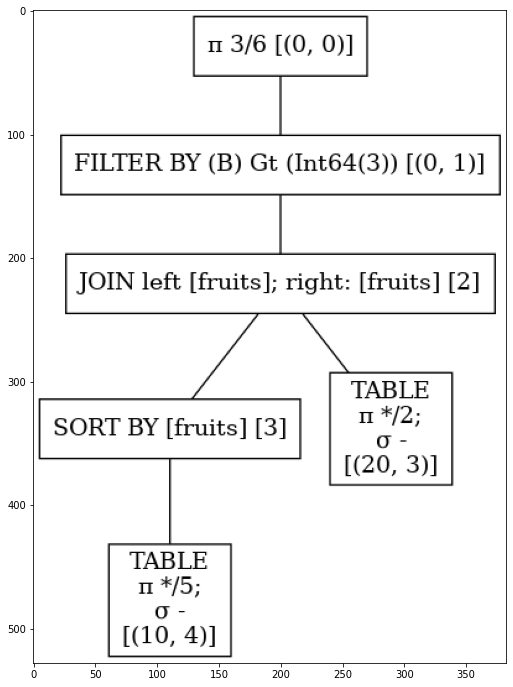

In [7]:
q.show_graph(optimized=False)

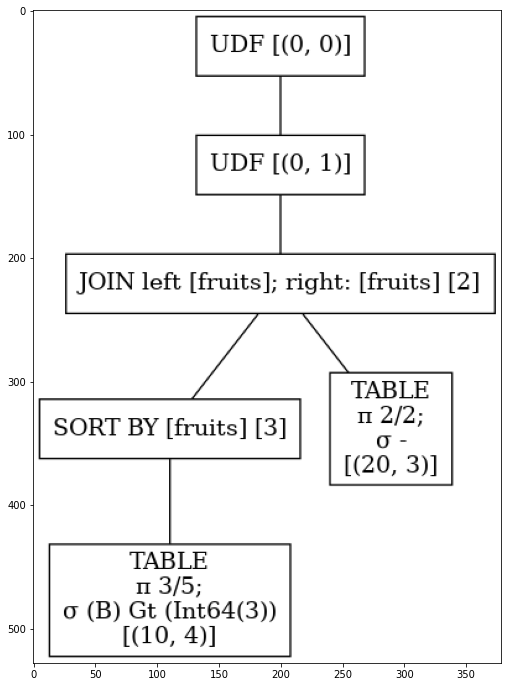

In [8]:
q.show_graph(optimized=True)